# 1. Reading Data & Preprocessing

In [1]:
import glob
import os
import random
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Dense
from keras import models
from sklearn.ensemble import IsolationForest
from keras import optimizers
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
os.chdir("/scratch/rk9cx/conn_log_labelled_runtime/labelled_2019-01-10//")

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#random sampling
filename = "merged.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 1000000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

In [3]:
#preprocessing data
df = pd.read_csv(filename, skiprows=skip)
df = df.drop(df.columns[0], axis=1)
df = pd.concat([df, df['history'].str.join('|').str.get_dummies()], axis = 1)
df = df.drop(["history","honeypot","blacklist","whitelist"], axis=1)
df = pd.concat([df, pd.get_dummies(df.conn_state.apply(pd.Series), prefix="", prefix_sep="")], axis = 1)
df = df.drop(["conn_state"], axis=1)
df = df.replace('-', 0)
df.head()

,ts,src_ip,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,...,RSTOS0,RSTR,RSTRH,S0,S1,S2,S3,SF,SH,SHR
0,1.547096e+09,194.28.115.245,47821,3.110.190.232,33897,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1.547096e+09,167.99.214.206,17731,3.110.144.95,80,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.547096e+09,3.110.95.233,61774,52.1.136.181,80,0.013601,159,1004,5,4,...,0,0,0,0,0,0,0,1,0,0
3,1.547096e+09,78.128.112.46,57462,3.110.30.43,20953,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1.547096e+09,58.59.133.198,64153,3.110.123.157,1433,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df.to_csv("sample.csv", index=False)

In [2]:
df = pd.read_csv("sample.csv", index_col= False)
df.head()

,ts,src_ip,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,...,RSTOS0,RSTR,RSTRH,S0,S1,S2,S3,SF,SH,SHR
0,1.547096e+09,194.28.115.245,47821,3.110.190.232,33897,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1.547096e+09,167.99.214.206,17731,3.110.144.95,80,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.547096e+09,3.110.95.233,61774,52.1.136.181,80,0.013601,159,1004,5,4,...,0,0,0,0,0,0,0,1,0,0
3,1.547096e+09,78.128.112.46,57462,3.110.30.43,20953,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1.547096e+09,58.59.133.198,64153,3.110.123.157,1433,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


# 5. Jeremy Howard's Methodology

In [3]:
from fastai.imports import *
from fastai.structured import *

## 5.1 Class Distribution - (Malicious/Benign) = (70/30)

In [4]:
rf_sample = df.drop(["src_ip_ext"], axis=1)
rf_sample["duration"] = rf_sample["duration"].astype(float)
rf_sample["duration"] = np.log((rf_sample["duration"].astype('int'))+0.001)
rf_sample["src_bytes"] = rf_sample["src_bytes"].astype(float)
rf_sample["src_bytes"] = np.log((rf_sample["src_bytes"].astype('int'))+0.001)
rf_sample["dest_bytes"] = rf_sample["dest_bytes"].astype(float)
rf_sample["dest_bytes"] = np.log((rf_sample["dest_bytes"].astype('int'))+0.001)
rf_sample["src_pkts"] = np.log((rf_sample["src_pkts"].astype('int'))+0.001)
rf_sample["dest_pkts"] = np.log((rf_sample["dest_pkts"].astype('int'))+0.001)
rf_sample['ts'] = pd.to_datetime(rf_sample['ts'],unit='s')
rf_sample["src_port"] = rf_sample["src_port"].astype('category')
rf_sample["src_ip"] = rf_sample["src_ip"].astype('category')
rf_sample["dest_ip"] = rf_sample["dest_ip"].astype('category')
rf_sample["dest_port"] = rf_sample["dest_port"].astype('category')
rf_sample["src_port"] = rf_sample["src_port"].cat.codes
rf_sample["dest_ip"] = rf_sample["dest_ip"].cat.codes
rf_sample["dest_port"] = rf_sample["dest_port"].cat.codes
rf_sample["src_ip"] = rf_sample["src_ip"].cat.codes

In [5]:
#converting date into different fatures
add_datepart(rf_sample, 'ts')

In [21]:
X = rf_sample.loc[:, rf_sample.columns != 'label']
Y = rf_sample.loc[:, rf_sample.columns == 'label']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [23]:
test = pd.concat([X_test, y_test], axis = 1)
mal = test.loc[test['label'] == 1]
ben = test.loc[test['label'] == 0].head(test.label.value_counts()[0])
test_df = pd.concat([mal,ben], axis = 0)
test_df.label.value_counts(normalize = True)
y_test_new = test_df["label"]
X_test_new = test_df.drop(["label"], axis = 1)
train = pd.concat([X_train, y_train], axis = 1)
mal = train.loc[train['label'] == 1].head(train.label.value_counts()[0])
ben = train.loc[train['label'] == 0]
train_df = pd.concat([mal,ben], axis = 0)
train_df.label.value_counts(normalize = True)
y_train_new = train_df["label"]
X_train_new = train_df.drop(["label"], axis = 1)

In [26]:
y_train_new.value_counts()

1    267689
0    267689
Name: label, dtype: int64

In [27]:
#subsetting train values for faster model execution
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
X_train_sub, _ = split_vals(X_train_new, 50000)
y_train_sub, _ = split_vals(y_train_new, 50000)

In [ ]:
import random
outliers_fraction = [0.25,0.2,0.15,0.1,0.05,0.01,0.001]
n_estimators=[100,200,300,400,500,600,700,800,900,1000]
max_features = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in range(10):
    a = random.choice(n_estimators)
    b = random.choice(max_features)
    c = random.choice(outliers_fraction)
    I = IsolationForest(n_estimators=a, max_features=b, contamination=c)
    I.fit(X_train)
    X_train["Iscores"+ str(i)] = I.predict(X_train)
    X_train["Iscores"+ str(i)] = [1 if x == -1 else 0 for x in X_train["Iscores"+ str(i)]]
    I.fit(X_test)
    X_test["Iscores"+ str(i)] = I.predict(X_test)
    X_test["Iscores"+ str(i)] = [1 if x == -1 else 0 for x in X_test["Iscores"+ str(i)]]

In [31]:
X_train_sep = X_train.T.tail(10).T
X_test_sep = X_test.T.tail(10).T

In [32]:
X_train_sep.head()

,Iscores0,Iscores1,Iscores2,Iscores3,Iscores4,Iscores5,Iscores6,Iscores7,Iscores8,Iscores9
378046,0,0,0,0,0,0,0,0,0,0
510062,0,0,0,0,0,0,0,0,0,0
534815,0,0,0,0,0,0,0,0,0,0
342590,0,0,0,0,0,0,0,0,0,0
559414,0,0,0,0,0,0,0,0,0,0


/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Confusion matrix, without normalization
[[17033 12811]
 [ 4158 65998]]


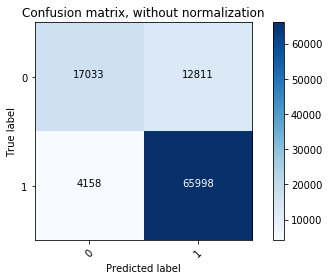

In [43]:
RF = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, max_features=0.6).fit(X_train_sep, y_train)
pred_y=RF.predict(X_test_sep)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [44]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.8374424240886194 0.940732082786932 42.92655140061654 83.031


In [37]:
accuracy = []
fpr = []
precision = []
recall = []
for i in range(10):
    if i == 0:
        continue
    RF = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, max_features=0.6)
    RF.fit(X_train.T.tail(X_test.shape[1]-34).head(i).T, y_train)
    pred_y=RF.predict(X_test.T.tail(X_test.shape[1]-34).head(i).T)
    cm= confusion_matrix(y_test,pred_y)
    tn, fp, fn, tp = cm.ravel()
    p=tp/(tp+fp)
    precision.append(p)
    r=tp/(tp+fn)
    recall.append(r)
    f = fp/(fp+ tn)
    fpr.append(f)
    a = (tp + tn)/(tn + tp + fn + fp)
    accuracy.append(a)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vect

In [38]:
k = list(range(1,10))
df = pd.DataFrame(
    {'k': k,
     'accuracy': accuracy,
     'fpr': fpr,
     'recall': recall,
     'precision': precision
    })

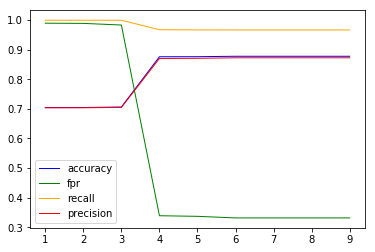

In [39]:
# multiple line plot
plt.plot( 'k', 'accuracy', data=df, marker='', color='blue', linewidth=1)
plt.plot( 'k', 'fpr', data=df, marker='', color='green', linewidth=1)
plt.plot( 'k', 'recall', data=df, marker='', color='orange', linewidth=1)
plt.plot( 'k', 'precision', data=df, marker='', color='red', linewidth=1)
plt.legend()

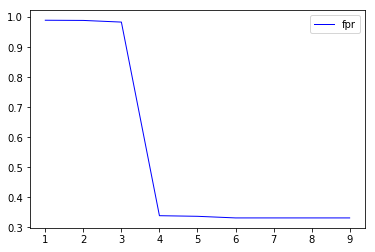

In [40]:
plt.plot( 'k', 'fpr', data=df, marker='', color='blue', linewidth=1)
plt.legend()

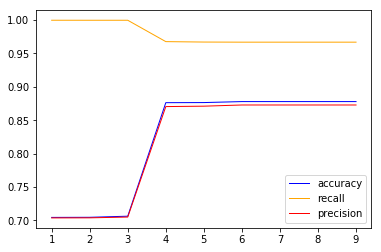

In [41]:
# multiple line plot
plt.plot( 'k', 'accuracy', data=df, marker='', color='blue', linewidth=1)
plt.plot( 'k', 'recall', data=df, marker='', color='orange', linewidth=1)
plt.plot( 'k', 'precision', data=df, marker='', color='red', linewidth=1)
plt.legend()

0.8374424240886194 0.940732082786932 42.92655140061654 83.031


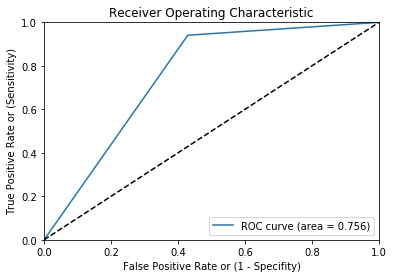

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [ ]:
df.to_csv("crickey.csv", index=False)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[ 85980  12256]
 [  1819 229945]]


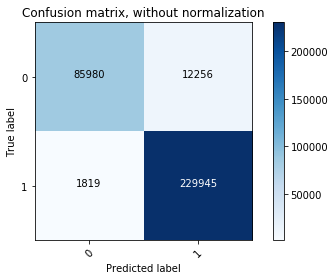

In [22]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [26]:
rf_sample[["label","local"]].corr()

,label,local
label,1.000000,-0.886087
local,-0.886087,1.000000


In [23]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9493974013319516 0.9921514989385755 12.476078016205872 95.73484848484848


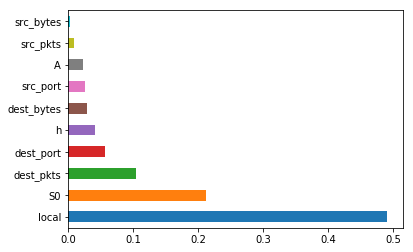

In [16]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

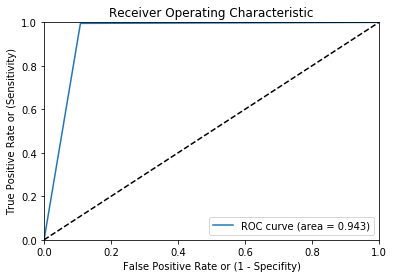

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.2 Class Distribution - (Malicious/Benign) - (50/50)

In [28]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500021
0    0.499979
Name: label, dtype: float64

In [29]:
X = rf_sampler.loc[:, rf_sample.columns != 'label']
Y = rf_sampler.loc[:, rf_sample.columns == 'label']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [33]:
X_train_sub, _ = split_vals(X_train, 500000)
y_train_sub, _ = split_vals(y_train, 500000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[95103  3483]
 [  821 97414]]


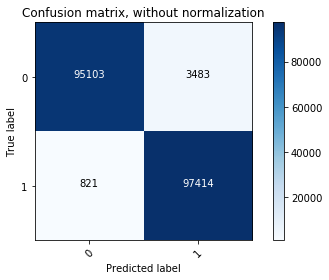

In [34]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [35]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9654796475613745 0.9916424899475746 3.5329559978090197 97.81324147321678


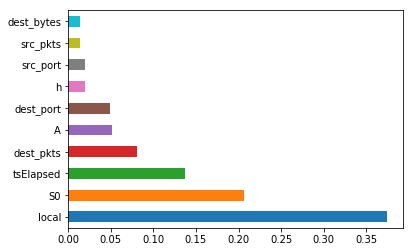

In [36]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

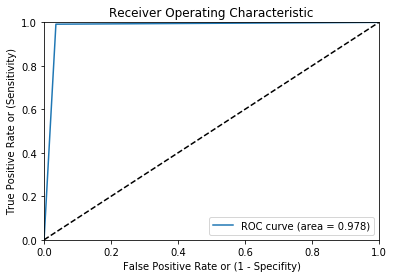

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.3 Class Distribution - (Malicious/Benign) - (10/90)

In [38]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(29822)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

0    0.909086
1    0.090914
Name: label, dtype: float64

In [39]:
X = rf_sampler.loc[:, rf_sample.columns != 'label']
Y = rf_sampler.loc[:, rf_sample.columns == 'label']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [41]:
X_train_sub, _ = split_vals(X_train, 500000)
y_train_sub, _ = split_vals(y_train, 500000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[97885   555]
 [   18  9790]]


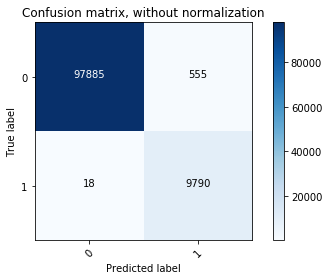

In [42]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [43]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9463508941517641 0.9981647634584013 0.5637952052011378 99.47065996600399


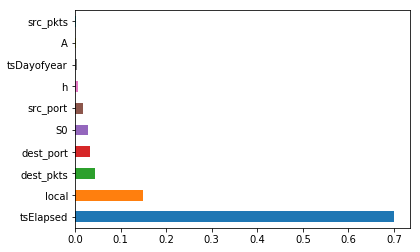

In [44]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

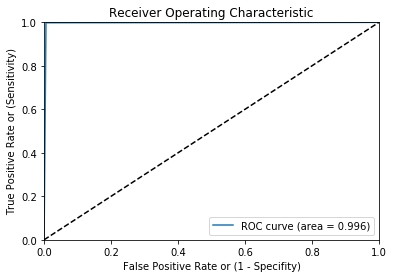

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.4 Class Distribution - (Malicious/Benign) - (1/99)

In [32]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500157
0    0.499843
Name: label, dtype: float64

In [33]:
X = rf_sampler.loc[:, rf_sample.columns != 'label']
Y = rf_sampler.loc[:, rf_sample.columns == 'label']

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [57]:
X_train_sub, _ = split_vals(X_train, 500000)
y_train_sub, _ = split_vals(y_train, 500000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[98311    70]
 [   10  1000]]


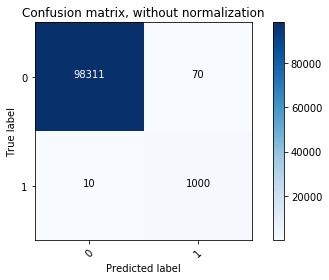

In [58]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [59]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9345794392523364 0.9900990099009901 0.07115195007166018 99.91950981477196


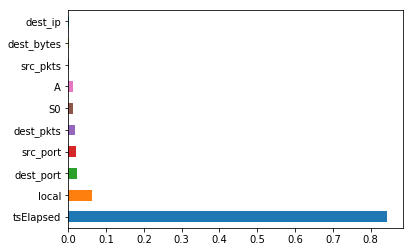

In [60]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

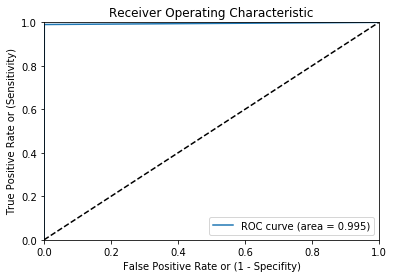

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.5 Models without Unix Time

In [34]:
rf_sample = df.drop(["src_ip_ext","src_ip"], axis=1)
rf_sample["duration"] = rf_sample["duration"].astype(float)
rf_sample["duration"] = np.log((rf_sample["duration"].astype('int'))+0.001)
rf_sample["src_bytes"] = rf_sample["src_bytes"].astype(float)
rf_sample["src_bytes"] = np.log((rf_sample["src_bytes"].astype('int'))+0.001)
rf_sample["dest_bytes"] = rf_sample["dest_bytes"].astype(float)
rf_sample["dest_bytes"] = np.log((rf_sample["dest_bytes"].astype('int'))+0.001)
rf_sample["src_pkts"] = np.log((rf_sample["src_pkts"].astype('int'))+0.001)
rf_sample["dest_pkts"] = np.log((rf_sample["dest_pkts"].astype('int'))+0.001)
rf_sample['ts'] = pd.to_datetime(rf_sample['ts'],unit='s')
rf_sample["src_port"] = rf_sample["src_port"].astype('category')
rf_sample["dest_ip"] = rf_sample["dest_ip"].astype('category')
rf_sample["dest_port"] = rf_sample["dest_port"].astype('category')
rf_sample["src_port"] = rf_sample["src_port"].cat.codes
rf_sample["dest_ip"] = rf_sample["dest_ip"].cat.codes
rf_sample["dest_port"] = rf_sample["dest_port"].cat.codes

In [8]:
#converting date into different fatures
add_datepart(rf_sample, 'ts')

In [10]:
rf_sample.columns

Index(['src_port', 'dest_ip', 'dest_port', 'duration', 'src_bytes',
       'dest_bytes', 'src_pkts', 'dest_pkts', 'local', 'label', 'A', 'D', 'F',
       'H', 'Q', 'R', 'S', 'T', '^', 'a', 'd', 'f', 'h', 'i', 'q', 'r', 't',
       'OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3',
       'SF', 'SH', 'SHR', 'tsYear', 'tsMonth', 'tsWeek', 'tsDay',
       'tsDayofweek', 'tsDayofyear', 'tsIs_month_end', 'tsIs_month_start',
       'tsIs_quarter_end', 'tsIs_quarter_start', 'tsIs_year_end',
       'tsIs_year_start'],
      dtype='object')

In [9]:
rf_sample.drop(["tsElapsed"], axis= 1, inplace=True)

In [11]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500582
0    0.499418
Name: label, dtype: float64

In [35]:
X = rf_sampler.loc[:, rf_sampler.columns != 'label']
Y = rf_sampler.loc[:, rf_sampler.columns == 'label']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
X_train.label

In [37]:
#subsetting train values for faster model execution
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
X_train_sub, _ = split_vals(X_train, 50000)
y_train_sub, _ = split_vals(y_train, 50000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[91273  7180]
 [  923 97392]]


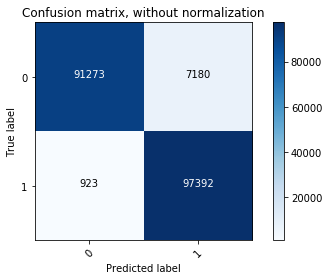

In [38]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_sub, y_train_sub) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [40]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9313391730099836 0.9906118089813355 7.292819924227804 95.8819523499756


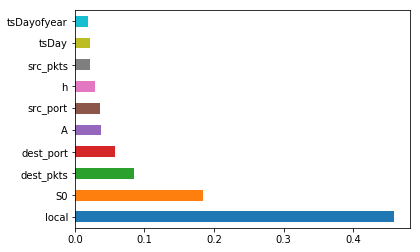

In [41]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

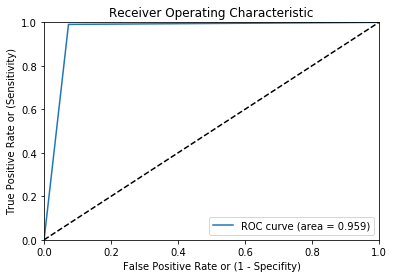

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 5.5 Train-Test Split based on timestamp

In [35]:
#converting date into different fatures
add_datepart(rf_sample, 'ts')

In [36]:
rf_sample = rf_sample.sort_values(by=['tsElapsed'], ascending=True)

In [51]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500582
0    0.499418
Name: label, dtype: float64

In [52]:
rf_sampler = rf_sampler.sort_values(by=['tsElapsed'], ascending=True)

In [53]:
#rf_sampler.drop(["tsElapsed"], axis= 1, inplace=True)

In [54]:
X = rf_sampler.loc[:, rf_sampler.columns != 'label']
Y = rf_sampler.loc[:, rf_sampler.columns == 'label']

In [55]:
X.shape

(595759, 52)

In [56]:
validation = 200000

In [57]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
# split point: length of dataset minus validation set size.
split_point = len(X)-validation

# split X
X_train, X_test = split_vals(X, split_point)

# split y
y_train, y_test = split_vals(Y, split_point)

In [58]:
X_train.tail()

,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,local,A,...,tsDay,tsDayofweek,tsDayofyear,tsIs_month_end,tsIs_month_start,tsIs_quarter_end,tsIs_quarter_start,tsIs_year_end,tsIs_year_start,tsElapsed
395153,60354,9542,412,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395160,43820,11382,2104,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395155,45531,41323,2918,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395158,33842,49113,32,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395149,39624,59423,412,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601


In [59]:
X_test.head()

,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,local,A,...,tsDay,tsDayofweek,tsDayofyear,tsIs_month_end,tsIs_month_start,tsIs_quarter_end,tsIs_quarter_start,tsIs_year_end,tsIs_year_start,tsElapsed
395150,48555,39347,3513,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395159,54028,16845,637,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395157,48555,66109,1001,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134601
395211,210,45215,12,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134602
395168,42255,9654,638,-6.907755,-6.907755,-6.907755,0.001,-6.907755,0,0,...,10,3,10,False,False,False,False,False,False,1547134602


In [60]:
#subsetting train values for faster model execution
X_train_sub, _ = split_vals(X_train, 50000)
y_train_sub, _ = split_vals(y_train, 50000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[177102  17583]
 [    43   5272]]


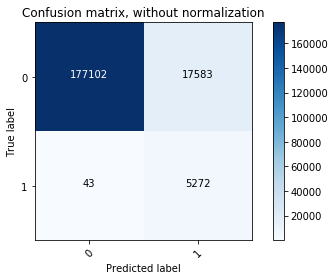

In [65]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [66]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.23067162546488734 0.9919096895578551 9.03151244317744 91.187


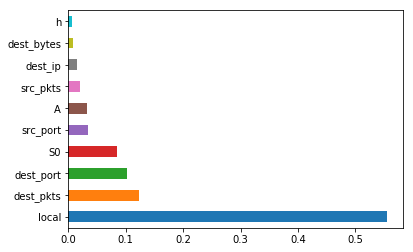

In [63]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

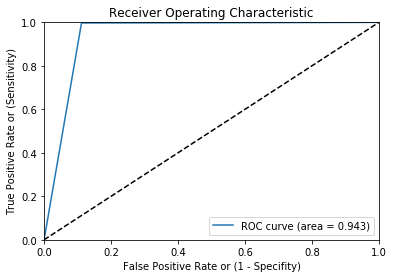

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

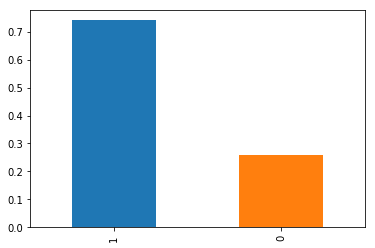

In [71]:
y_train.label.value_counts(normalize = True).plot('bar')

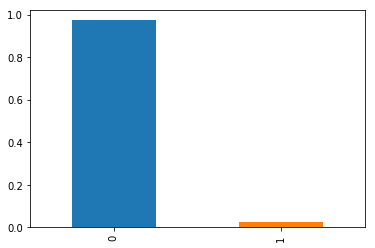

In [72]:
y_test.label.value_counts(normalize = True).plot('bar')

## 5.6 Train-Test Split based on timestamp (Without tsElapsed)

In [7]:
#converting date into different fatures
add_datepart(rf_sample, 'ts')

In [13]:
rf_sample = rf_sample.sort_values(by=['tsElapsed'], ascending=True)

In [14]:
mal = rf_sample.loc[rf_sample['label'] == 1].head(298226)
ben = rf_sample.loc[rf_sample['label'] == 0]
rf_sampler = pd.concat([mal,ben], axis = 0)
rf_sampler.label.value_counts(normalize = True)

1    0.500582
0    0.499418
Name: label, dtype: float64

In [15]:
rf_sampler = rf_sampler.sort_values(by=['tsElapsed'], ascending=True)

In [16]:
rf_sampler.drop(["tsElapsed"], axis= 1, inplace=True)

In [17]:
X = rf_sampler.loc[:, rf_sampler.columns != 'label']
Y = rf_sampler.loc[:, rf_sampler.columns == 'label']

In [21]:
Y.label.value_counts()

1    298226
0    297533
Name: label, dtype: int64

In [22]:
validation = 200000

In [23]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
# split point: length of dataset minus validation set size.
split_point = len(X)-validation

# split X
X_train, X_test = split_vals(X, split_point)

# split y
y_train, y_test = split_vals(Y, split_point)

In [25]:
y_test.label.value_counts(normalize=True)

0    0.973425
1    0.026575
Name: label, dtype: float64

In [84]:
#subsetting train values for faster model execution
X_train_sub, _ = split_vals(X_train, 50000)
y_train_sub, _ = split_vals(y_train, 50000)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Confusion matrix, without normalization
[[177747  16938]
 [    48   5267]]


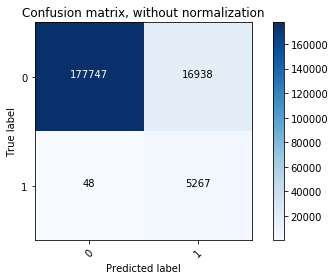

In [92]:
m = RandomForestClassifier(n_estimators=500, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train) 
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [93]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.23719882909254672 0.9909689557855127 8.700208028353494 91.507


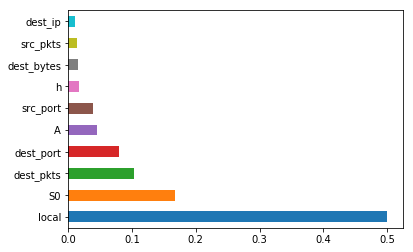

In [94]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

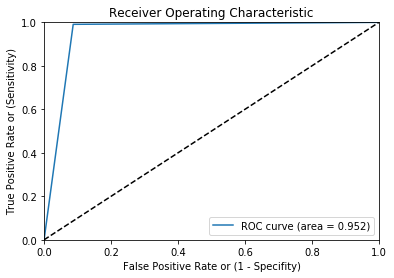

In [95]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

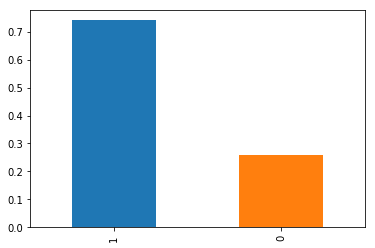

In [96]:
y_train.label.value_counts(normalize = True).plot('bar')

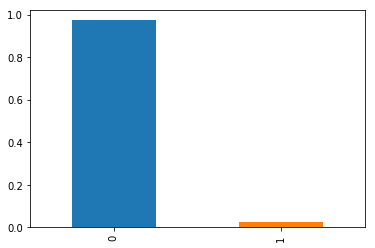

In [97]:
y_test.label.value_counts(normalize = True).plot('bar')

## 5.7 Train-Test Split based on timestamp (Without tsElapsed) - With Better Class Balance in Test

In [26]:
test = pd.concat([X_test, y_test], axis = 1)

In [27]:
test.label.value_counts()

0    194685
1      5315
Name: label, dtype: int64

In [28]:
mal = test.loc[test['label'] == 1]
ben = test.loc[test['label'] == 0].head(5315)
test_df = pd.concat([mal,ben], axis = 0)
test_df.label.value_counts(normalize = True)

1    0.5
0    0.5
Name: label, dtype: float64

In [29]:
y_test_new = test_df["label"]
X_test_new = test_df.drop(["label"], axis = 1)

In [30]:
train = pd.concat([X_train, y_train], axis = 1)

In [31]:
train.label.value_counts()

1    292911
0    102848
Name: label, dtype: int64

In [32]:
mal = train.loc[train['label'] == 1].head(102848)
ben = train.loc[train['label'] == 0]
train_df = pd.concat([mal,ben], axis = 0)
train_df.label.value_counts(normalize = True)

1    0.5
0    0.5
Name: label, dtype: float64

In [33]:
y_train_new = train_df["label"]
X_train_new = train_df.drop(["label"], axis = 1)

In [34]:
m = RandomForestClassifier(n_estimators=500, min_samples_leaf=100, max_features=0.5, n_jobs=-1)
m.fit(X_train_new, y_train_new) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion matrix, without normalization
[[5147  168]
 [ 127 5188]]


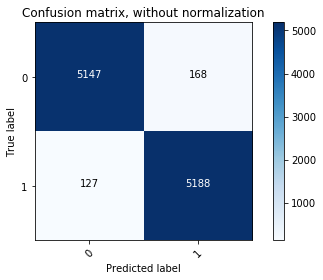

In [38]:
pred_y = m.predict(X_test_new)
cm= confusion_matrix(y_test_new, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [39]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9686333084391336 0.9761053621825023 3.160865475070555 97.22483537158983


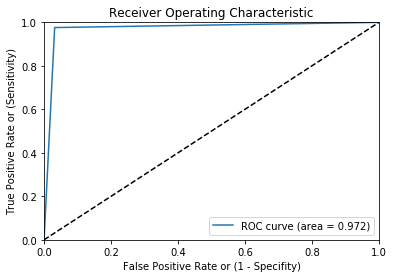

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test_new, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

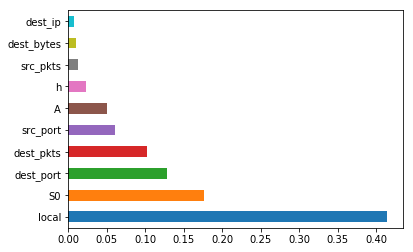

In [41]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [34]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
df.head()

,ts,src_ip,src_port,dest_ip,dest_port,duration,src_bytes,dest_bytes,src_pkts,dest_pkts,...,RSTOS0,RSTR,RSTRH,S0,S1,S2,S3,SF,SH,SHR
0,1.547096e+09,194.28.115.245,47821,3.110.190.232,33897,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1.547096e+09,167.99.214.206,17731,3.110.144.95,80,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.547096e+09,3.110.95.233,61774,52.1.136.181,80,0.013601,159,1004,5,4,...,0,0,0,0,0,0,0,1,0,0
3,1.547096e+09,78.128.112.46,57462,3.110.30.43,20953,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1.547096e+09,58.59.133.198,64153,3.110.123.157,1433,0.000000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
